<a href="https://colab.research.google.com/github/SummerToday/ai/blob/main/manandgirl(transfer_learning).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
from torch.autograd import Variable
import torch.nn.functional as F

import torchvision
import torchvision.transforms as transforms
from torch.utils.data import Dataset, DataLoader

import os
import time
import copy
import glob
import cv2
import shutil

import torchvision.models as models

import torch.optim as optim


from google.colab import files # 데이터 불러오기
file_uploaded=files.upload()   # 데이터 불러오기: chap05/data/catndog.zip 파일 선택

Exception ignored in: <function WeakSet.__init__.<locals>._remove at 0x7f7cefedff40>
Traceback (most recent call last):
  File "/usr/lib/python3.10/_weakrefset.py", line 39, in _remove
    def _remove(item, selfref=ref(self)):
KeyboardInterrupt: 


Saving manandgirl.zip to manandgirl.zip


In [2]:
!unzip manandgirl.zip -d manandgirl/    #catanddog 폴더 만들어 압축 풀기

Archive:  manandgirl.zip
   creating: manandgirl/manandgirl/
   creating: manandgirl/manandgirl/test/
   creating: manandgirl/manandgirl/test/girl/
  inflating: manandgirl/manandgirl/test/girl/112944.jpg.jpg  
  inflating: manandgirl/manandgirl/test/girl/112950.jpg.jpg  
  inflating: manandgirl/manandgirl/test/girl/112953.jpg.jpg  
  inflating: manandgirl/manandgirl/test/girl/112956.jpg.jpg  
  inflating: manandgirl/manandgirl/test/girl/112959.jpg.jpg  
  inflating: manandgirl/manandgirl/test/girl/112961.jpg.jpg  
  inflating: manandgirl/manandgirl/test/girl/112967.jpg.jpg  
  inflating: manandgirl/manandgirl/test/girl/112968.jpg.jpg  
  inflating: manandgirl/manandgirl/test/girl/112970.jpg.jpg  
  inflating: manandgirl/manandgirl/test/girl/112973.jpg.jpg  
  inflating: manandgirl/manandgirl/test/girl/112974.jpg.jpg  
  inflating: manandgirl/manandgirl/test/girl/112979.jpg.jpg  
  inflating: manandgirl/manandgirl/test/girl/112987.jpg.jpg  
  inflating: manandgirl/manandgirl/test/girl/1

In [3]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# Dataset 구축

In [4]:
# train daatset
data_path = 'manandgirl/manandgirl/train/'
transform = transforms.Compose(
                [
                    transforms.Resize([256, 256]),
                    transforms.RandomResizedCrop(224),
                    transforms.RandomHorizontalFlip(),
                    transforms.ToTensor(),
                ])
train_dataset = torchvision.datasets.ImageFolder(
    data_path,
    transform=transform
)
train_loader = torch.utils.data.DataLoader(
    train_dataset,
    batch_size=32,
    num_workers=8,
    shuffle=True
)

print(len(train_dataset))

2000


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


In [5]:
# test dataset
test_path = 'manandgirl/manandgirl/test/'

transform = transforms.Compose(
                [
                    transforms.Resize(224),
                    transforms.CenterCrop(224),
                    transforms.ToTensor(),
                ])
test_dataset = torchvision.datasets.ImageFolder(
    root=test_path,
    transform=transform
)
test_loader = torch.utils.data.DataLoader(
    test_dataset,
    batch_size=32,
    num_workers=1,
    shuffle=True
)

print(len(test_dataset))

400


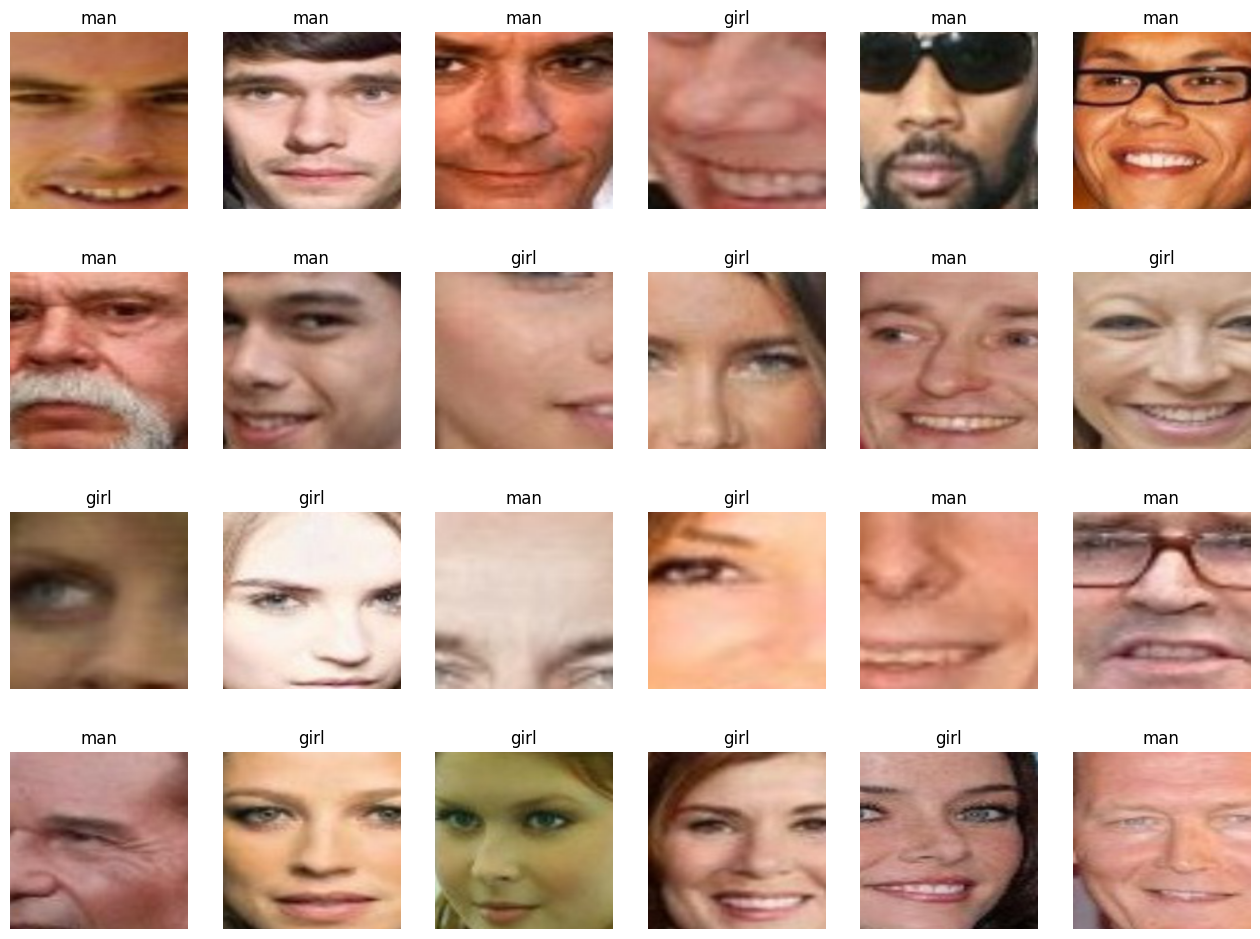

In [6]:
# check dataset
samples, labels = next(iter(train_loader))
classes = {0:'girl', 1:'man'}
fig = plt.figure(figsize=(16,24))
for i in range(24):
    a = fig.add_subplot(4,6,i+1)
    a.set_title(classes[labels[i].item()])
    a.axis('off')
    a.imshow(np.transpose(samples[i].numpy(), (1,2,0)))
plt.subplots_adjust(bottom=0.2, top=0.6, hspace=0)

## 전이 학습을 위한 코드 추가

In [7]:
# 모델 변경 가능
resnet18 = models.resnet18(pretrained=True)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 68.7MB/s]


In [8]:
def set_parameter_requires_grad(model, feature_extracting=True):
    if feature_extracting:
        for param in model.parameters():
            param.requires_grad = False
            
set_parameter_requires_grad(resnet18)

In [9]:
resnet18.fc = nn.Linear(512, 2)#완전 연결층 추가

In [10]:
for name, param in resnet18.named_parameters():
    if param.requires_grad:
        print(name, param.data)

fc.weight tensor([[-0.0034, -0.0027,  0.0063,  ...,  0.0302, -0.0094, -0.0082],
        [ 0.0278, -0.0305, -0.0058,  ...,  0.0146, -0.0283, -0.0314]])
fc.bias tensor([-0.0057,  0.0223])


In [12]:
model = models.resnet18(pretrained = True)

for param in model.parameters():
    param.requires_grad = False

model.fc = torch.nn.Linear(512, 2)
for param in model.fc.parameters():
    param.requires_grad = True

optimizer = torch.optim.Adam(model.fc.parameters())
cost = torch.nn.CrossEntropyLoss()
print(model)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [13]:
# TL-update parameter
params_to_update = []
for name,param in resnet18.named_parameters():
    if param.requires_grad == True:
        params_to_update.append(param)
        print("\t",name)
            
optimizer = optim.Adam(params_to_update)

	 fc.weight
	 fc.bias


# FashionCNN 모델 구축

In [18]:
class FashionCNN(nn.Module):    
    def __init__(self):
        super(FashionCNN, self).__init__()        
        self.layer1 = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )       
        self.layer2 = nn.Sequential(
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(2)
        )        
        self.fc1 = nn.Linear(in_features=64*55*55, out_features=800)
        self.drop = nn.Dropout2d(0.25)
        self.fc2 = nn.Linear(in_features=800, out_features=240)
        self.fc3 = nn.Linear(in_features=240, out_features=2)
        
    def forward(self, x):
        out = self.layer1(x)
        out = self.layer2(out)
        out = out.view(out.size(0), -1)
        out = self.fc1(out)
        out = self.drop(out)
        out = self.fc2(out)
        out = self.fc3(out)       
        return out

In [19]:
# CNN-update parameter

learning_rate = 0.001;
model = FashionCNN();
model.to(device)


criterion = nn.CrossEntropyLoss();
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate);
print(model)

FashionCNN(
  (layer1): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (layer2): Sequential(
    (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (fc1): Linear(in_features=193600, out_features=800, bias=True)
  (drop): Dropout2d(p=0.25, inplace=False)
  (fc2): Linear(in_features=800, out_features=240, bias=True)
  (fc3): Linear(in_features=240, out_features=2, bias=True)
)


# Training and Test

In [14]:
def train_model(model, dataloaders, criterion, optimizer, device, num_epochs=5, is_train=True):
    since = time.time()    
    acc_history = []
    loss_history = []
    best_acc = 0.0
    
    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        running_loss = 0.0
        running_corrects = 0

        for inputs, labels in dataloaders:
            inputs = inputs.to(device)
            labels = labels.to(device)
            
            model.to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            _, preds = torch.max(outputs, 1)
            loss.backward()
            optimizer.step()

            running_loss += loss.item() * inputs.size(0)
            running_corrects += torch.sum(preds == labels.data)

        epoch_loss = running_loss / len(dataloaders.dataset)
        epoch_acc = running_corrects.double() / len(dataloaders.dataset)

        print('Loss: {:.4f} Acc: {:.4f}'.format(epoch_loss, epoch_acc))

        if epoch_acc > best_acc:
            best_acc = epoch_acc

        acc_history.append(epoch_acc.item())
        loss_history.append(epoch_loss)        
        torch.save(model.state_dict(), os.path.join('manandgirl/', '{0:0=2d}.pth'.format(epoch)))
        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))
    print('Best Acc: {:4f}'.format(best_acc))    
    return acc_history, loss_history

In [15]:
def eval_model(model, dataloaders, device):
    since = time.time()    
    acc_history = []
    best_acc = 0.0

    saved_models = glob.glob('manandgirl/' + '*.pth')
    saved_models.sort()
    print('saved_model', saved_models)

    for model_path in saved_models:
        print('Loading model', model_path)

        model.load_state_dict(torch.load(model_path))
        model.eval()
        model.to(device)
        running_corrects = 0

        for inputs, labels in dataloaders:
            inputs = inputs.to(device)
            labels = labels.to(device)

            with torch.no_grad():
                outputs = model(inputs)

            _, preds = torch.max(outputs.data, 1)           
            preds[preds >= 0.5] = 1
            preds[preds < 0.5] = 0
            running_corrects += preds.eq(labels).int().sum()
            
        epoch_acc = running_corrects.double() / len(dataloaders.dataset)
        print('Acc: {:.4f}'.format(epoch_acc))
        
        if epoch_acc > best_acc:
            best_acc = epoch_acc

        acc_history.append(epoch_acc.item())
        print()

    time_elapsed = time.time() - since
    print('Validation complete in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))
    print('Best Acc: {:4f}'.format(best_acc))
    
    return acc_history



In [20]:
# 전이 학습 training
TL_train_acc_hist, TL_train_loss_hist = train_model(resnet18, train_loader, criterion, optimizer, device)

# 전이 학습 test
TL_val_acc_hist = eval_model(resnet18, test_loader, device)

Epoch 0/4
----------


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Loss: 0.7395 Acc: 0.4850

Epoch 1/4
----------
Loss: 0.7446 Acc: 0.4900

Epoch 2/4
----------
Loss: 0.7332 Acc: 0.5015

Epoch 3/4
----------
Loss: 0.7400 Acc: 0.4835

Epoch 4/4
----------
Loss: 0.7430 Acc: 0.4885

Training complete in 16m 33s
Best Acc: 0.501500
saved_model ['manandgirl/00.pth', 'manandgirl/01.pth', 'manandgirl/02.pth', 'manandgirl/03.pth', 'manandgirl/04.pth']
Loading model manandgirl/00.pth
Acc: 0.4650

Loading model manandgirl/01.pth
Acc: 0.4425

Loading model manandgirl/02.pth
Acc: 0.4450

Loading model manandgirl/03.pth
Acc: 0.4500

Loading model manandgirl/04.pth
Acc: 0.4375

Validation complete in 2m 56s
Best Acc: 0.465000


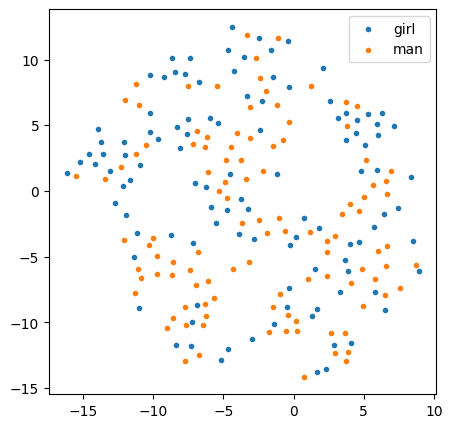

In [ ]:
# 전이 학습 TSNE
actual = []
deep_features = []

with torch.no_grad():
    for data in test_loader:
        images, labels = data[0].to(device), data[1].to(device)
        features = resnet18(images)

        deep_features += features.cpu().numpy().tolist()
        actual += labels.cpu().numpy().tolist()

from sklearn.manifold import TSNE
tsne = TSNE(n_components=2, random_state=0)
cluster = np.array(tsne.fit_transform(np.array(deep_features)))
actual = np.array(actual)

plt.figure(figsize=(5, 5))
name = ['girl', 'man']
for i, label in zip(range(2), name):
    idx = np.where(actual == i)
    plt.scatter(cluster[idx, 0], cluster[idx, 1], marker='.', label=label)

plt.legend()
plt.show()

In [ ]:
# CNN training
train_acc_hist, train_loss_hist = train_model(model, train_loader, criterion, optimizer, device)

# CNN test
val_acc_hist = eval_model(model, test_loader, device)

Epoch 0/9
----------


/usr/local/lib/python3.10/dist-packages/torch/nn/functional.py:1331: UserWarning: dropout2d: Received a 2-D input to dropout2d, which is deprecated and will result in an error in a future release. To retain the behavior and silence this warning, please use dropout instead. Note that dropout2d exists to provide channel-wise dropout on inputs with 2 spatial dimensions, a channel dimension, and an optional batch dimension (i.e. 3D or 4D inputs).
  warnings.warn(warn_msg)


Loss: 141.2213 Acc: 0.4952

Epoch 1/9
----------
Loss: 69.3983 Acc: 0.5238

Epoch 2/9
----------
Loss: 14.6205 Acc: 0.4810

Epoch 3/9
----------
Loss: 9.1145 Acc: 0.5333

Epoch 4/9
----------
Loss: 10.3700 Acc: 0.5333

Epoch 5/9
----------
Loss: 4.2562 Acc: 0.5476

Epoch 6/9
----------
Loss: 2.5002 Acc: 0.5571

Epoch 7/9
----------
Loss: 2.2823 Acc: 0.5857

Epoch 8/9
----------
Loss: 1.3186 Acc: 0.5905

Epoch 9/9
----------
Loss: 0.9471 Acc: 0.6048

Training complete in 1m 10s
Best Acc: 0.604762
saved_model ['manandgirl/00.pth', 'manandgirl/01.pth', 'manandgirl/02.pth', 'manandgirl/03.pth', 'manandgirl/04.pth', 'manandgirl/05.pth', 'manandgirl/06.pth', 'manandgirl/07.pth', 'manandgirl/08.pth', 'manandgirl/09.pth']
Loading model manandgirl/00.pth
Acc: 0.5000

Loading model manandgirl/01.pth
Acc: 0.5000

Loading model manandgirl/02.pth
Acc: 0.5139

Loading model manandgirl/03.pth
Acc: 0.5000

Loading model manandgirl/04.pth
Acc: 0.6019

Loading model manandgirl/05.pth
Acc: 0.6157

Loadin

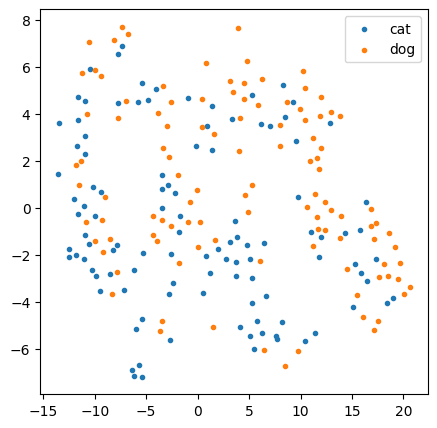

In [ ]:
# CNN TSNE
actual = []
deep_features = []

model.eval()
with torch.no_grad():
    for data in test_loader:
        images, labels = data[0].to(device), data[1].to(device)
        features = model(images)

        deep_features += features.cpu().numpy().tolist()
        actual += labels.cpu().numpy().tolist()

from sklearn.manifold import TSNE
tsne = TSNE(n_components=2, random_state=0)
cluster = np.array(tsne.fit_transform(np.array(deep_features)))
actual = np.array(actual)

plt.figure(figsize=(5, 5))
name = ['cat', 'dog']
for i, label in zip(range(2), name):
    idx = np.where(actual == i)
    plt.scatter(cluster[idx, 0], cluster[idx, 1], marker='.', label=label)

plt.legend()
plt.show()

# 전이 학습 vs CNN

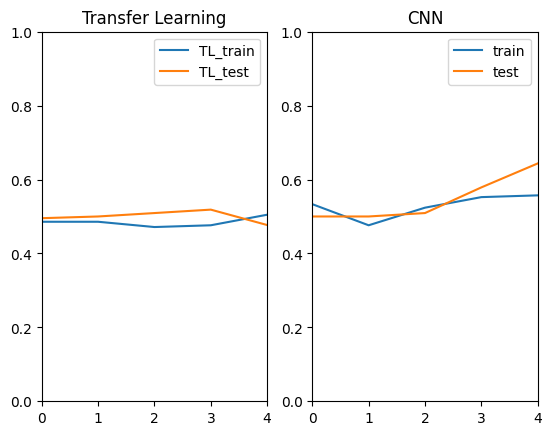

In [ ]:
# plt.plot(train_acc_hist)
# plt.plot(val_acc_hist)
# plt.show()

plt.subplot(121)
plt.plot(TL_train_acc_hist, label="TL_train")
plt.plot(TL_val_acc_hist, label="TL_test")
plt.xlim([0, 4])
plt.ylim([0, 1])
plt.legend()
plt.title("Transfer Learning")

plt.subplot(122)
plt.plot(train_acc_hist, label="train")
plt.plot(val_acc_hist, label="test")
plt.xlim([0, 4])
plt.ylim([0, 1])
plt.legend()
plt.title("CNN")

plt.show()

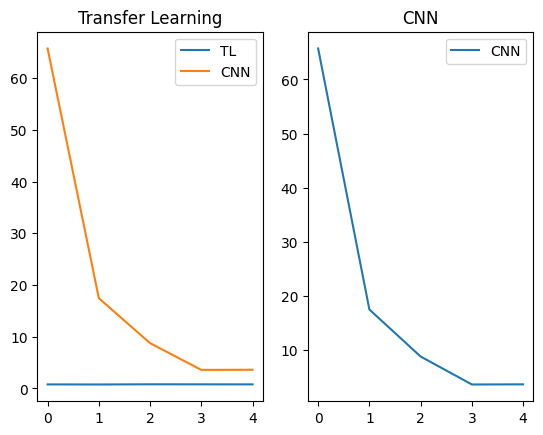

In [ ]:
plt.subplot(121)
plt.plot(TL_train_loss_hist, label="TL")
plt.plot(train_loss_hist, label="CNN")
# plt.xlim([0, 4])
# plt.ylim([0, 1])
plt.legend()
plt.title("Transfer Learning")

plt.subplot(122)
plt.plot(train_loss_hist, label="CNN")
# plt.xlim([0, 4])
# plt.ylim([0, 1])
plt.legend()
plt.title("CNN")

plt.show()